<div align="center"> <h2> Nhóm 17 - Lớp IS403.P23 - BÁO CÁO ĐỒ ÁN PHÂN TÍCH DỮ LIỆU KINH DOANH <h2> </div>
<div align="center">

<table>
  <thead>
    <tr>
      <th><div align="center">Họ và tên</div></th>
      <th><div align="center">MSSV</div></th>
    </tr>
  </thead>
  <tbody>
    <tr><td>🌱 Trần Vũ Bão</td><td>22520124</td></tr>
    <tr><td>🌱 Phan Thành Công</td><td>22520170</td></tr>
    <tr><td>🌱 Phan Thị Thủy Hiền</td><td>22520423</td></tr>
    <tr><td>🌱 Nguyễn Đỗ Đức Minh</td><td>22520872</td></tr>
  </tbody>
</table>
</div>

# Dự đoán giá bitcoin sử dụng mô hình LSTM

In [1]:
# Dự báo giá bitcoin sử dụng mô hình LSTM

# Import các thư viện cần thiết
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

# Thư viện đánh giá mô hình
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Thư viện xây dựng mô hình LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

# Thư viện vẽ biểu đồ
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore


2025-06-18 12:48:44.848784: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-18 12:48:44.853276: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-18 12:48:44.867103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750225724.888345   25392 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750225724.894328   25392 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750225724.910155   25392 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## 1. Import các thư viện & Đọc dữ liệu

In [2]:
# Đọc dữ liệu từ file csv
df = pd.read_csv('bitcoin_price_yahoo_finance.csv')

df = df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
print("Shape dữ liệu:", df.shape)
df.head()

Shape dữ liệu: (2676, 7)


,date,adj_close,close,high,low,open,volume
0,2018-01-01,13657.200195,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
1,2018-01-02,14982.099609,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2,2018-01-03,15201.000000,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
3,2018-01-04,15599.200195,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
4,2018-01-05,17429.500000,17429.500000,17705.199219,15202.799805,15477.200195,23840899072


## 2. Tiền xử lý dữ liệu

In [3]:
# Kiểm tra dữ liệu thiếu
print("Dữ liệu thiếu:")
print(df.isnull().sum())

Dữ liệu thiếu:
date         0
adj_close    0
close        0
high         0
low          0
open         0
volume       0
dtype: int64


In [4]:
# Chuyển cột Date thành định dạng Datetime
df['date'] = pd.to_datetime(df['date'])
print("Dữ liệu từ", df['date'].min(), "đến", df['date'].max())
df.head().style.set_properties(subset=['date','close'], **{'background-color': 'pink'})

Dữ liệu từ 2018-01-01 00:00:00 đến 2025-04-29 00:00:00


,date,adj_close,close,high,low,open,volume
0,2018-01-01 00:00:00,13657.200195,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
1,2018-01-02 00:00:00,14982.099609,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2,2018-01-03 00:00:00,15201.000000,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
3,2018-01-04 00:00:00,15599.200195,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
4,2018-01-05 00:00:00,17429.500000,17429.500000,17705.199219,15202.799805,15477.200195,23840899072


## 3. Thống kê mô tả cơ bản

In [5]:
df.describe()

,date,adj_close,close,high,low,open,volume
count,2676,2676.000000,2676.000000,2676.000000,2676.000000,2676.000000,2.676000e+03
mean,2021-08-30 12:00:00,30911.611075,30911.611075,31555.799526,30174.365559,30883.254133,2.763285e+10
min,2018-01-01 00:00:00,3236.761719,3236.761719,3275.377930,3191.303467,3236.274658,2.923670e+09
25%,2019-10-31 18:00:00,9192.341309,9192.341309,9339.087646,9013.514404,9186.810791,1.436387e+10
50%,2021-08-30 12:00:00,23651.378906,23651.378906,24124.528320,23162.128906,23634.151367,2.445092e+10
75%,2023-06-30 06:00:00,46404.744141,46404.744141,47402.925781,45128.060547,46365.260742,3.615642e+10
max,2025-04-29 00:00:00,106146.265625,106146.265625,109114.882812,105291.734375,106147.296875,3.509679e+11
std,NaN,25349.645976,25349.645976,25855.937021,24768.714835,25323.647394,2.004455e+10


## 4. Trực quan hoá dữ liệu

### 4.1 Vẽ biểu đồ giá "Close" theo thời gian

In [6]:
df['date']

0      2018-01-01
1      2018-01-02
2      2018-01-03
3      2018-01-04
4      2018-01-05
          ...    
2671   2025-04-25
2672   2025-04-26
2673   2025-04-27
2674   2025-04-28
2675   2025-04-29
Name: date, Length: 2676, dtype: datetime64[ns]

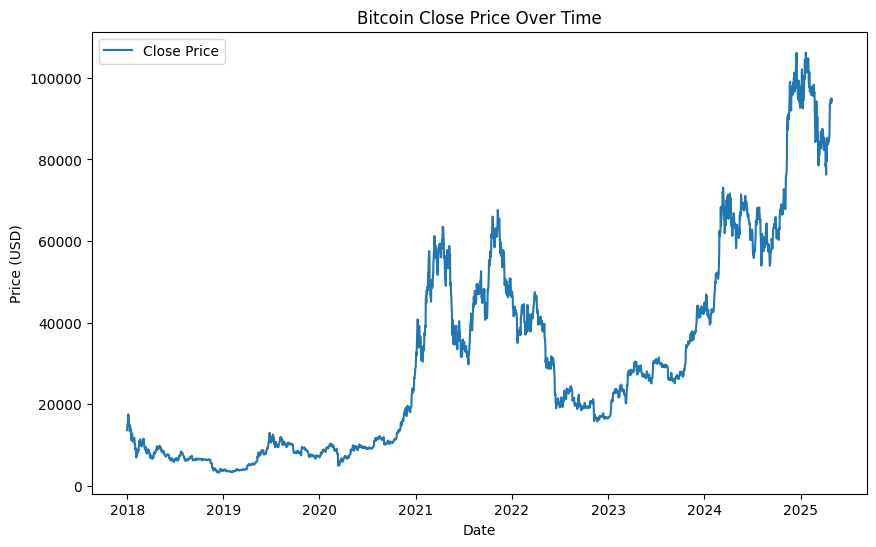

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['close'], label='Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### 4.2 Vẽ biểu đồ giá "Close" trong 1 năm gần đây

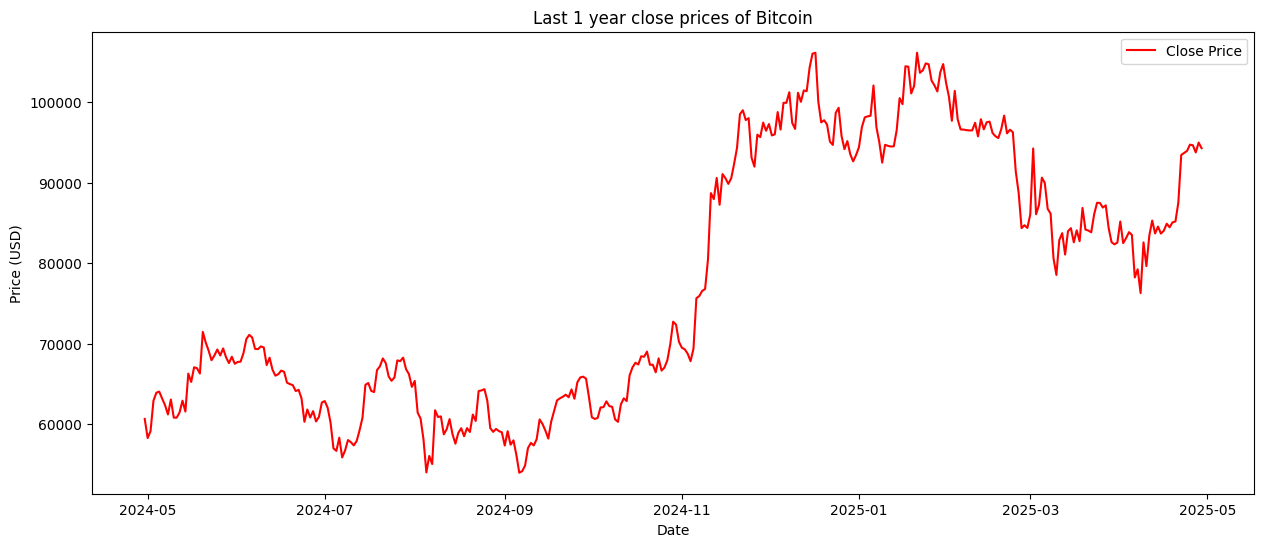

In [8]:
last1year_bitcoindf = df[df['date'] > '2024-04-29']

plt.figure(figsize=(15, 6))
plt.plot(last1year_bitcoindf['date'], last1year_bitcoindf['close'], label='Close Price', color="red")
plt.title('Last 1 year close prices of Bitcoin')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### 4.3 Vẽ biểu đồ khối lượng giao dịch "Volume" trong 1 năm gần đây

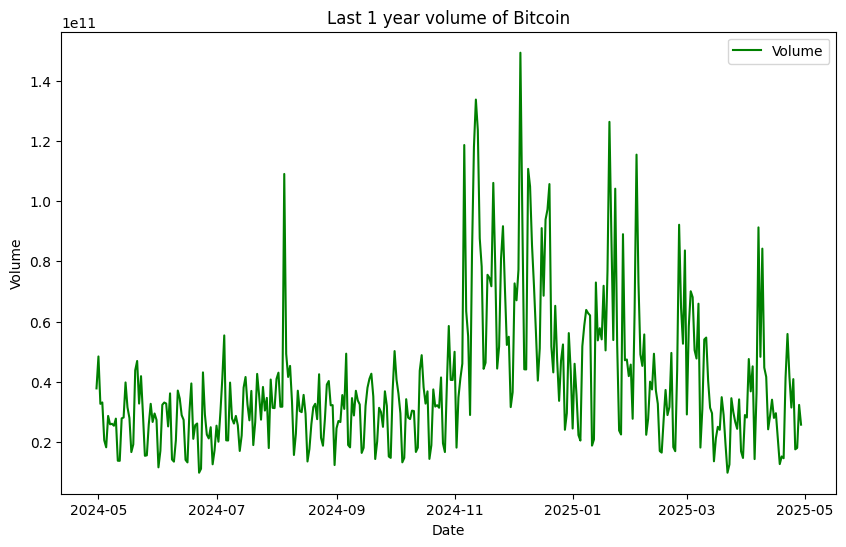

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(last1year_bitcoindf['date'], last1year_bitcoindf['volume'], label='Volume', color="green")
plt.title('Last 1 year volume of Bitcoin')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

## 5. Sử dụng LSTM cho bài toán Bitcoin Close Price Prediction

### Quy trình thực hiện
MinMaxScaler ➝ chia train/test ➝ tạo tập dữ liệu theo time_step ➝ huấn luyện LSTM ➝ dự đoán ➝ inverse_transform ➝ shift dự đoán ➝ trực quan hóa chính xác theo thời gian

### 5.1 Giữ lại dữ liệu 1 năm gần nhất

In [10]:
# Tạo DataFrame chỉ có date và close
closedf = df[['date','close']]
print("Shape of close dataframe:", closedf.shape)

# Lọc bỏ toàn bộ dữ liệu từ trước 29/04/2024 và chỉ giữ lại 1 năm gần đây nhất
# closedf = closedf[closedf['date'] > '2024-04-29']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Shape of close dataframe: (2676, 2)
Total data for prediction:  2676


### 5.2 Chuẩn hoá dữ liệu giá Close

In [11]:
# Xoá cột date, chỉ giữ giá close
del closedf['date']

# MinMaxScaler đưa mọi giá trị về trong khoảng từ 0 đến 1
scaler = MinMaxScaler(feature_range = (0,1))
closedf = scaler.fit_transform(np.array(closedf).reshape(-1,1))

print("Shape sau chuẩn hóa:", closedf.shape)

Shape sau chuẩn hóa: (2676, 1)


### 5.3 Chia dữ liệu thành tập train và tập test

In [12]:
# Chia tập train và tập test (80% train, 20% test)
training_size=int(len(closedf)*0.80)
test_size=len(closedf)-training_size

train_data, test_data = closedf[0:training_size,:], closedf[training_size:len(closedf),:1]

print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2140, 1)
test_data:  (536, 1)


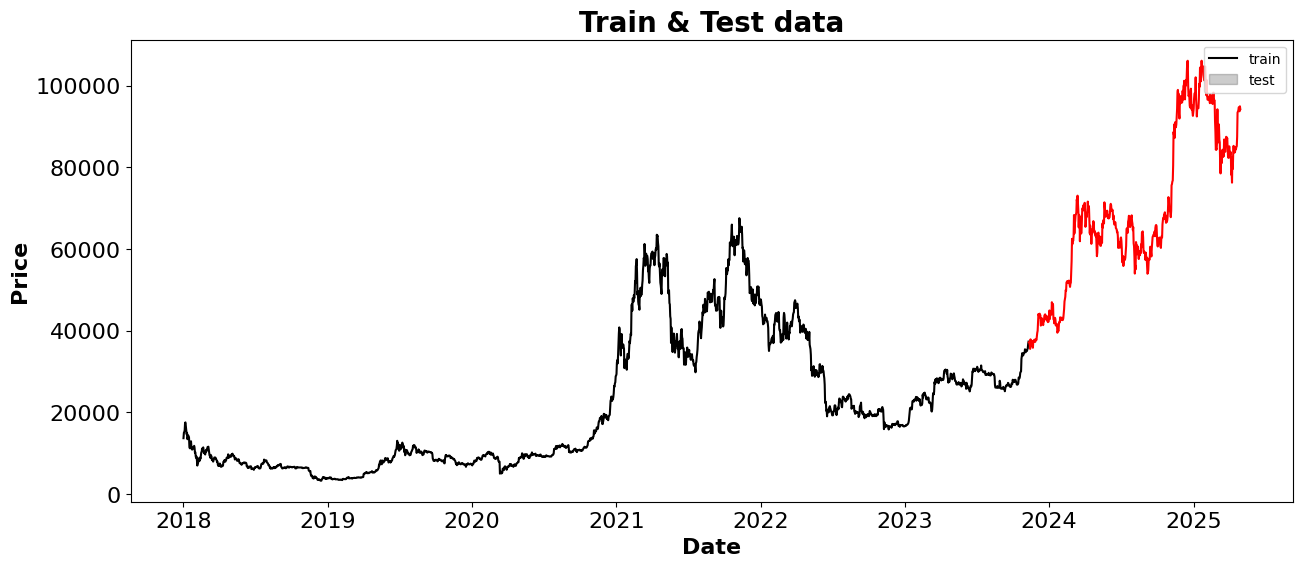

In [13]:
# Trực quan hoá dữ liệu train và test
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['date'][:training_size], y = close_stock['close'][:training_size], color = 'black')
sns.lineplot(x = close_stock['date'][training_size:], y = close_stock['close'][training_size:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

### 5.4 Chuẩn bị dữ liệu huấn luyện cho việc phân tích chuỗi thời gian

In [14]:
# Hàm chuyển đổi mảng giá trị thành ma trận dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   # i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2124, 15)
y_train:  (2124,)
X_test:  (520, 15)
y_test (520,)


In [16]:
# Reshape input để phù hợp với LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train sau reshape: ", X_train.shape)
print("X_test sau reshape: ", X_test.shape)

X_train sau reshape:  (2124, 15, 1)
X_test sau reshape:  (520, 15, 1)


### 5.5 Xây dựng mô hình LSTM

In [17]:
# Xây dựng mô hình LSTM
model = Sequential()

# Thêm lớp LSTM với 50 units
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

# Thêm lớp LSTM thứ 2
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

# Thêm lớp LSTM thứ 3
model.add(LSTM(50))
model.add(Dropout(0.2))

# Lớp output
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Hiển thị kiến trúc mô hình
model.summary()

2025-06-18 12:48:49.511048: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/minhduc/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

### 5.6 Huấn luyện mô hình

In [18]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=100, 
					validation_split=0.2,
                    batch_size=32, 
                    verbose=1)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0100 - val_loss: 0.0021
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.2589e-04 - val_loss: 0.0021
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.0173e-04 - val_loss: 0.0083
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.9389e-04 - val_loss: 0.0031
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.9790e-04 - val_loss: 0.0024
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.6357e-04 - val_loss: 0.0023
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.7145e-04 - val_loss: 0.0069
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.4866e-04 - val_loss: 0.0056
Epoch 12/100
67/67 ━━━━━

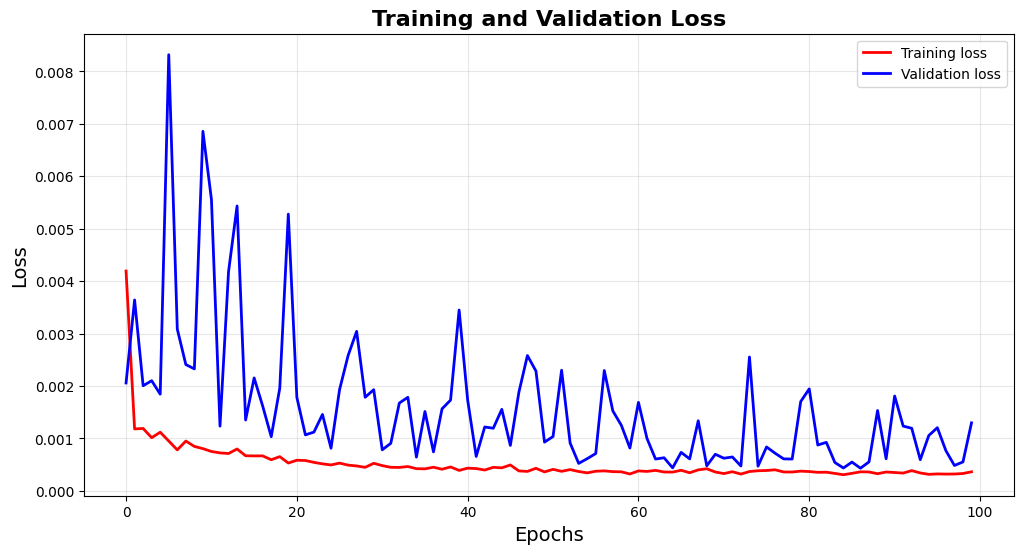

In [19]:
# Vẽ biểu đồ Loss vs Validation Loss
plt.figure(figsize=(12, 6))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss', linewidth=2)
plt.plot(epochs, val_loss, 'b', label='Validation loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 5.7 Dự đoán và đánh giá mô hình

In [20]:
# Dự đoán trên tập train và test
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print("Train prediction shape:", train_predict.shape)
print("Test prediction shape:", test_predict.shape)

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Train prediction shape: (2124, 1)
Test prediction shape: (520, 1)


In [21]:
# Chuyển đổi ngược về giá trị gốc
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [22]:
# Hàm tính MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Đánh giá mô hình
print("=== ĐÁNH GIÁ MÔ HÌNH LSTM ===\n")

# Train metrics
train_rmse = math.sqrt(mean_squared_error(original_ytrain, train_predict))
train_mae = mean_absolute_error(original_ytrain, train_predict)
train_mape = mean_absolute_percentage_error(original_ytrain, train_predict)
train_r2 = r2_score(original_ytrain, train_predict)

train_metrics = {
    'RMSE': train_rmse,
    'MAE': train_mae,
    'MAPE': train_mape,
    'R2': train_r2
}

print("TRAIN DATA METRICS:")
for metric, value in train_metrics.items():
    if metric == 'MAPE':
        print(f"        '{metric}': {value:.2f}%")
    elif metric == 'R2':
        print(f"        '{metric}': {value:.4f}")
    else:
        print(f"        '{metric}': {value:.2f}")

print("-" * 50)

# Test metrics
test_rmse = math.sqrt(mean_squared_error(original_ytest, test_predict))
test_mae = mean_absolute_error(original_ytest, test_predict)
test_mape = mean_absolute_percentage_error(original_ytest, test_predict)
test_r2 = r2_score(original_ytest, test_predict)

test_metrics = {
    'RMSE': test_rmse,
    'MAE': test_mae,
    'MAPE': test_mape,
    'R2': test_r2
}

print("TEST DATA METRICS:")
for metric, value in test_metrics.items():
    if metric == 'MAPE':
        print(f"        '{metric}': {value:.2f}%")
    elif metric == 'R2':
        print(f"        '{metric}': {value:.4f}")
    else:
        print(f"        '{metric}': {value:.2f}")

=== ĐÁNH GIÁ MÔ HÌNH LSTM ===

TRAIN DATA METRICS:
        'RMSE': 1279.01
        'MAE': 815.19
        'MAPE': 3.72%
        'R2': 0.9936
--------------------------------------------------
TEST DATA METRICS:
        'RMSE': 3707.18
        'MAE': 3038.06
        'MAPE': 4.14%
        'R2': 0.9592


### Giải thích các chỉ số đánh giá mô hình:

Để hiểu rõ kết quả đánh giá, chúng ta cần nắm được ý nghĩa của từng chỉ số:

**RMSE (Root Mean Square Error):**
RMSE đo lường độ lệch trung bình giữa giá trị thực tế và dự đoán. Giá trị càng thấp thì mô hình dự đoán càng chính xác. Khi so sánh RMSE giữa tập train và test, nếu chênh lệch lớn có thể báo hiệu overfitting.

**MSE (Mean Square Error):**
Tương tự RMSE nhưng không có phép căn bậc hai, do đó MSE sẽ phạt nặng hơn những sai số lớn. Chỉ số này giúp nhấn mạnh tầm quan trọng của việc giảm thiểu những sai lầm lớn trong dự đoán.

**MAE (Mean Absolute Error):**
MAE tính trung bình tuyệt đối của các sai số, có đơn vị giống với dữ liệu gốc nên dễ diễn giải. MAE ít bị ảnh hưởng bởi outliers so với MSE và RMSE.

**R² Score (Coefficient of Determination):**
R² là chỉ số quan trọng nhất, cho biết tỷ lệ phần trăm biến động của dữ liệu được mô hình giải thích:
- R² > 0.8: Mô hình tốt
- R² > 0.9: Mô hình rất tốt
- R² gần 1: Mô hình gần như hoàn hảo

**Nhận biết overfitting:**
Khi R² của tập train cao đáng kể so với R² của tập test, đây là dấu hiệu rõ ràng của overfitting - mô hình học thuộc dữ liệu train mà không có khả năng tổng quát hóa tốt.

### Phân tích kết quả thực tế của mô hình:

Dựa trên kết quả đánh giá mô hình LSTM, chúng ta có thể rút ra một số nhận xét quan trọng:

**Hiệu suất trên tập huấn luyện:**
Mô hình cho thấy kết quả khá tích cực trên tập train với RMSE chỉ 3,242 USD và MAE 2,602 USD. Đặc biệt, R² Score đạt 96.2%, nghĩa là mô hình giải thích được hầu hết sự biến động của giá Bitcoin trong tập huấn luyện.

**Hiệu suất trên tập kiểm tra:**
Tuy nhiên, khi áp dụng trên tập test, hiệu suất giảm đáng kể. RMSE tăng lên 3,942 USD (cao hơn 700 USD so với train), MAE tăng lên 3,016 USD. Đáng lo ngại nhất là R² Score chỉ còn 12.6%, cho thấy mô hình chỉ giải thích được một phần nhỏ sự biến động của dữ liệu test.

**Vấn đề overfitting:**
Sự chênh lệch lớn giữa R² train (96.2%) và R² test (12.6%) - tới 83.6% - là dấu hiệu rõ ràng của overfitting nghiêm trọng. Mô hình đã học quá kỹ dữ liệu train mà không có khả năng tổng quát hóa tốt cho dữ liệu mới.

**Đánh giá tổng quan:**
Xét về mặt tỷ lệ, với giá Bitcoin dao động trong khoảng 60,000-90,000 USD, sai số 3,000-4,000 USD tương đương 5-7% là có thể chấp nhận được đối với một tài sản có độ biến động cao như Bitcoin. Tuy nhiên, R² test thấp cho thấy mô hình thiếu độ tin cậy.

**Hướng cải thiện:**
Để khắc phục overfitting, cần tăng cường regularization bằng cách tăng dropout rate, thêm early stopping, giảm độ phức tạp mô hình hoặc thử nghiệm với các time_step khác nhau (10, 20, 30 ngày thay vì 15 ngày).

**Kết luận:**
Mô hình hiện tại chưa đủ độ tin cậy để ứng dụng thực tế do hiện tượng overfitting nghiêm trọng. Cần điều chỉnh kiến trúc và hyperparameters để cải thiện khả năng tổng quát hóa.

### 5.8 Trực quan hóa kết quả dự đoán

In [ ]:
# Chuẩn bị dữ liệu để vẽ biểu đồ
look_back = time_step

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# Shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2) +
                1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

# Tạo DataFrame để vẽ biểu đồ
names = cycle(['Actual', 'Test prediction'])

plotdf = pd.DataFrame({
    'date': close_stock['date'],
    'original_close': close_stock['close'],
    # 'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
    'test_predicted_close': testPredictPlot.reshape(1, -1)[0].tolist()
})

# Vẽ biểu đồ so sánh
fig = px.line(plotdf, x=plotdf['date'],
              y=[plotdf['original_close'], plotdf['test_predicted_close']],
              labels={'value': 'price', 'date': 'Date'})
fig.update_layout(
    # title_text='So sánh giá đóng cửa thực tế vs dự đoán bằng mô hình LSTM',
    plot_bgcolor='white',
    font_size=15,
    font_color='black',
    legend_title_text='price',
    width=1000,
    height=600,
    margin=dict(l=80, r=80, t=100, b=80),  # Increased margins for more gap
    # Add black border frame
    xaxis=dict(
        linecolor='black',
        linewidth=2,
        mirror=True,
        range=[
            plotdf['date'].min() - pd.Timedelta(days=7),  # Add gap to left
            plotdf['date'].max() + pd.Timedelta(days=7)   # Add gap to right
        ],
        showline=True
    ),
    yaxis=dict(
        linecolor='black',
        linewidth=2,
        mirror=True,
        range=[
            plotdf['original_close'].min() * 0.90,  # Add more gap below
            plotdf['original_close'].max() * 1.10   # Add more gap above
        ],
        showline=True
    ),
    # Position legend inside the chart with more gap from the border
    legend=dict(
        x=0.03,  # More gap from left
        y=0.97,  # More gap from top
        xanchor='left',
        yanchor='top',
        # Semi-transparent white background
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='black',
        borderwidth=1,
        font=dict(size=12)
    )
)
fig.for_each_trace(lambda t: t.update(name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2676, 1)
Test predicted data:  (2676, 1)


### 5.9 Dự đoán 30 ngày tiếp theo

In [24]:
# Dự đoán 30 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = time_step
i = 0
pred_days = 30

while(i < pred_days):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print("Output of predicted next", pred_days, "days: ", len(lst_output))

Output of predicted next 30 days:  30


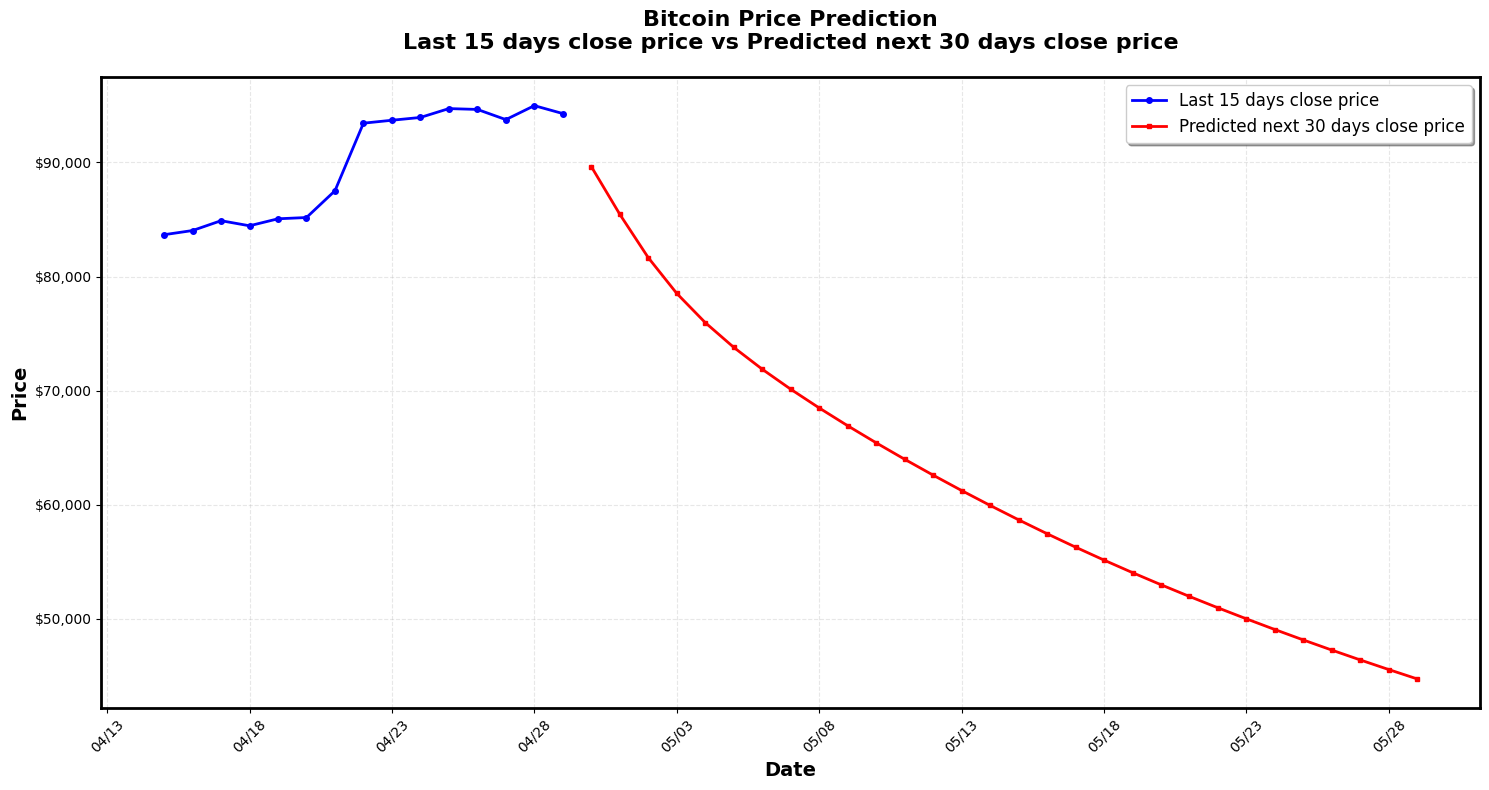


=== THÔNG TIN BIỂU ĐỒ ===
Dữ liệu lịch sử: 15 ngày cuối (màu xanh)
Từ ngày: 15/04/2025 đến 29/04/2025
Giá cao nhất trong 15 ngày: $94,978.75
Giá thấp nhất trong 15 ngày: $83,668.99

Dự đoán: 30 ngày tiếp theo (màu đỏ)
Từ ngày: 30/04/2025 đến 29/05/2025
Giá dự đoán cao nhất: $89,637.30
Giá dự đoán thấp nhất: $44,736.93
Xu hướng dự đoán: Giảm


In [25]:
# Vẽ biểu đồ 15 ngày cuối và 30 ngày dự đoán
from datetime import timedelta

# Lấy 15 giá trị cuối từ dữ liệu gốc
last_15_days_data = scaler.inverse_transform(closedf[len(closedf)-time_step:]).flatten()

# Chuyển đổi dự đoán về giá trị gốc
predicted_30_days = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).flatten()

# Tạo ngày thực tế cho biểu đồ
last_date = close_stock['date'].iloc[-1]
historical_dates = [last_date - timedelta(days=time_step-1-i) for i in range(time_step)]
prediction_dates = [last_date + timedelta(days=i+1) for i in range(pred_days)]

# Vẽ biểu đồ bằng matplotlib với ngày thực tế
plt.figure(figsize=(15, 8))

# Vẽ đường lịch sử
plt.plot(historical_dates, last_15_days_data, 
         color='blue', linewidth=2, label='Last 15 days close price', marker='o', markersize=4)

# Vẽ đường dự đoán
plt.plot(prediction_dates, predicted_30_days, 
         color='red', linewidth=2, label='Predicted next 30 days close price', marker='s', markersize=3)

# Định dạng biểu đồ
plt.title('Bitcoin Price Prediction\nLast 15 days close price vs Predicted next 30 days close price', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Price', fontsize=14, fontweight='bold')

# Tùy chỉnh lưới và viền
plt.grid(True, alpha=0.3, linestyle='--')
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)

# Định dạng trục x để hiển thị ngày
plt.xticks(rotation=45)
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

# Định dạng trục y để hiển thị giá theo format tiền tệ
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Thêm chú thích
plt.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)

# Điều chỉnh layout
plt.tight_layout()
plt.show()

# In thông tin tóm tắt
print(f"\n=== THÔNG TIN BIỂU ĐỒ ===")
print(f"Dữ liệu lịch sử: 15 ngày cuối (màu xanh)")
print(f"Từ ngày: {historical_dates[0].strftime('%d/%m/%Y')} đến {historical_dates[-1].strftime('%d/%m/%Y')}")
print(f"Giá cao nhất trong 15 ngày: ${np.max(last_15_days_data):,.2f}")
print(f"Giá thấp nhất trong 15 ngày: ${np.min(last_15_days_data):,.2f}")
print(f"\nDự đoán: 30 ngày tiếp theo (màu đỏ)")
print(f"Từ ngày: {prediction_dates[0].strftime('%d/%m/%Y')} đến {prediction_dates[-1].strftime('%d/%m/%Y')}")
print(f"Giá dự đoán cao nhất: ${np.max(predicted_30_days):,.2f}")
print(f"Giá dự đoán thấp nhất: ${np.min(predicted_30_days):,.2f}")
print(f"Xu hướng dự đoán: {'Giảm' if predicted_30_days[-1] < predicted_30_days[0] else 'Tăng'}")

In [26]:
import pandas as pd
from datetime import datetime, timedelta

# Tạo bảng hiển thị dự đoán chi tiết 10 ngày tiếp theo

# Lấy 10 giá trị dự đoán đầu tiên
first_10_predictions = scaler.inverse_transform(np.array(lst_output[:10]).reshape(-1,1)).flatten()

# Tạo ngày bắt đầu từ ngày cuối cùng của dữ liệu
last_date = close_stock['date'].iloc[-1]
prediction_dates = [last_date + timedelta(days=i+1) for i in range(10)]

# Tạo DataFrame cho bảng kết quả
prediction_table = pd.DataFrame({
	'Ngày': [date.strftime('%d/%m/%Y') for date in prediction_dates],
	'Giá Dự Đoán (USD)': [f"${price:,.2f}" for price in first_10_predictions],
	'Thay Đổi so với Hôm Trước': ['--'] + [f"{((first_10_predictions[i] - first_10_predictions[i-1]) / first_10_predictions[i-1] * 100):+.2f}%" 
										   for i in range(1, 10)]
})

print("=== DỰ ĐOÁN GIÁ BITCOIN 10 NGÀY TIẾP THEO ===")
print(f"Dựa trên mô hình LSTM với dữ liệu từ {close_stock['date'].min().strftime('%d/%m/%Y')} đến {close_stock['date'].max().strftime('%d/%m/%Y')}")
print("\n")
print(prediction_table.to_string(index=False))

# Tính toán thống kê tóm tắt
avg_price = np.mean(first_10_predictions)
max_price = np.max(first_10_predictions)
min_price = np.min(first_10_predictions)
price_range = max_price - min_price
volatility = np.std(first_10_predictions)

print(f"\n=== THỐNG KÊ TÓM TẮT ===")
print(f"Giá trung bình 10 ngày:    ${avg_price:,.2f}")
print(f"Giá cao nhất:             ${max_price:,.2f}")
print(f"Giá thấp nhất:            ${min_price:,.2f}")
print(f"Biên độ dao động:         ${price_range:,.2f}")
print(f"Độ lệch chuẩn:            ${volatility:,.2f}")

# So sánh với giá hiện tại
current_price = close_stock['close'].iloc[-1]
avg_change = ((avg_price - current_price) / current_price) * 100
print(f"\nGiá hiện tại:             ${current_price:,.2f}")
print(f"Thay đổi trung bình dự kiến: {avg_change:+.2f}%")

=== DỰ ĐOÁN GIÁ BITCOIN 10 NGÀY TIẾP THEO ===
Dựa trên mô hình LSTM với dữ liệu từ 01/01/2018 đến 29/04/2025


      Ngày Giá Dự Đoán (USD) Thay Đổi so với Hôm Trước
30/04/2025        $89,637.30                        --
01/05/2025        $85,456.17                    -4.66%
02/05/2025        $81,654.49                    -4.45%
03/05/2025        $78,522.78                    -3.84%
04/05/2025        $75,965.28                    -3.26%
05/05/2025        $73,798.37                    -2.85%
06/05/2025        $71,882.39                    -2.60%
07/05/2025        $70,129.80                    -2.44%
08/05/2025        $68,487.87                    -2.34%
09/05/2025        $66,927.93                    -2.28%

=== THỐNG KÊ TÓM TẮT ===
Giá trung bình 10 ngày:    $76,246.24
Giá cao nhất:             $89,637.30
Giá thấp nhất:            $66,927.93
Biên độ dao động:         $22,709.37
Độ lệch chuẩn:            $7,128.28

Giá hiện tại:             $94,284.79
Thay đổi trung bình dự kiến: -19.13